In [1]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
from scipy.stats import uniform #for training and test splits
import statsmodels.api as smf #R-like model specification
import matplotlib.pyplot as plt #2D plotting
import statsmodels.api as sm  # logistic regression
import statsmodels.formula.api as smf  # R-like model specification
import patsy  # translate model specification into design matrices
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING

In [2]:
 # read in hotels data and create data frame
hotels = pd.read_csv("hotel_booking_data_cleaned.csv")

print(pd.DataFrame.head(hotels))

hotels.describe()

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1     

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [4]:
# Create dummy variables for 'customer_type' and 'deposit_type'
dummy_columns = ['customer_type', 'deposit_type']
dummy_df = pd.get_dummies(hotels[dummy_columns])

# Concatenate the dummy variables with the original DataFrame
hotels_with_dummies = pd.concat([hotels, dummy_df], axis=1)

#drop the original columns
hotels_with_dummies.drop(columns=dummy_columns, inplace=True)

print(pd.DataFrame.head(hotels_with_dummies))

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1                        0        

Does the type of customer, deposit, and/or family size play a role in whether or not a reservation is cancelled?

In [5]:
import statsmodels.api as sm
# Drop rows with missing values in any column
hotels2 = hotels_with_dummies.dropna()
# Define the independent variables and the dependent variable
X = hotels2[['adults', 'children', 'babies', 'deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable',
             'customer_type_Transient-Party', 'customer_type_Transient', 'customer_type_Group', 'customer_type_Contract']]
y = hotels2['is_canceled']

# Add a constant to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Fit the linear regression model
modelAll = sm.OLS(y, X).fit()

# Print the summary of the regression
print(modelAll.summary())

                            OLS Regression Results                            
Dep. Variable:            is_canceled   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                    0.2582
Date:                Tue, 27 Feb 2024   Prob (F-statistic):              0.969
Time:                        04:40:21   Log-Likelihood:                -21.809
No. Observations:                 217   AIC:                             59.62
Df Residuals:                     209   BIC:                             86.66
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [6]:
import statsmodels.api as sm

# Define the independent variables and the dependent variable
X = hotels2[['adults', 'children', 'babies']]
y = hotels2['is_canceled']

# Add a constant to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Fit the linear regression model
modelAll = sm.OLS(y, X).fit()

# Print the summary of the regression
print(modelAll.summary())

                            OLS Regression Results                            
Dep. Variable:            is_canceled   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.2339
Date:                Tue, 27 Feb 2024   Prob (F-statistic):              0.792
Time:                        04:40:21   Log-Likelihood:                -22.506
No. Observations:                 217   AIC:                             51.01
Df Residuals:                     214   BIC:                             61.15
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1048      0.053      1.961      0.0

/Users/medjennapierre/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [7]:
import statsmodels.api as sm

# Define the independent variables and the dependent variable
X = hotels2[['deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable']]
y = hotels2['is_canceled']

# Add a constant to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Fit the linear regression model
modelAll = sm.OLS(y, X).fit()

# Print the summary of the regression
print(modelAll.summary())

                            OLS Regression Results                            
Dep. Variable:            is_canceled   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.1711
Date:                Tue, 27 Feb 2024   Prob (F-statistic):              0.843
Time:                        04:40:21   Log-Likelihood:                -22.570
No. Observations:                 217   AIC:                             51.14
Df Residuals:                     214   BIC:                             61.28
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [8]:
import statsmodels.api as sm

# Define the independent variables and the dependent variable
X = hotels2[['customer_type_Transient-Party', 'customer_type_Transient', 'customer_type_Group', 'customer_type_Contract']]
y = hotels2['is_canceled']

# Add a constant to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Fit the linear regression model
modelAll = sm.OLS(y, X).fit()

# Print the summary of the regression
print(modelAll.summary())

                            OLS Regression Results                            
Dep. Variable:            is_canceled   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.4495
Date:                Tue, 27 Feb 2024   Prob (F-statistic):              0.718
Time:                        04:40:21   Log-Likelihood:                -22.058
No. Observations:                 217   AIC:                             52.12
Df Residuals:                     213   BIC:                             65.64
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

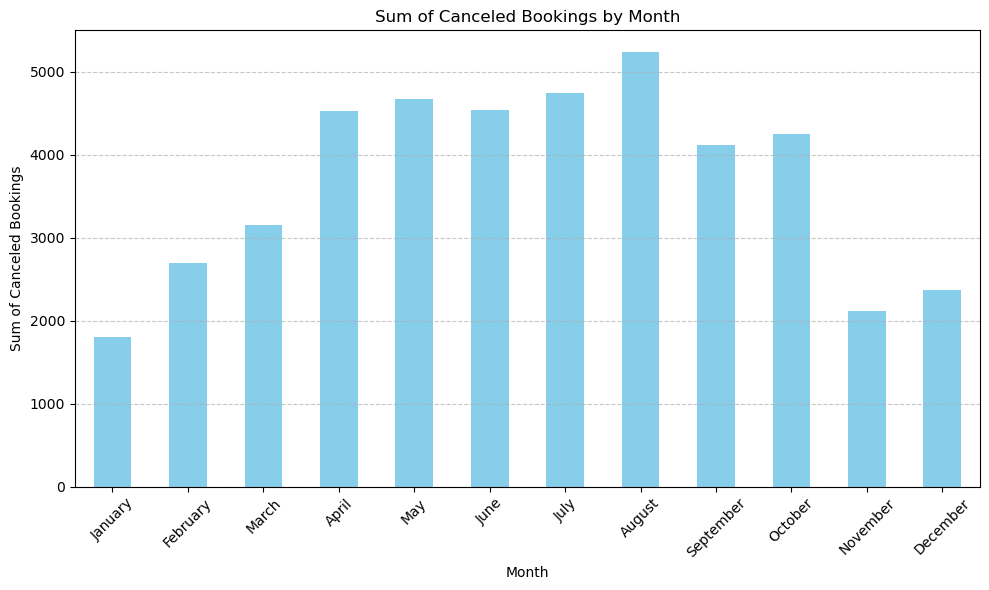

In [6]:
# Group the data by 'arrival_date_month' and calculate the sum of 'is_canceled' for each month
canceled_by_month = hotels.groupby('arrival_date_month')['is_canceled'].sum()

# Sort the data by month to ensure proper ordering in the plot
canceled_by_month = canceled_by_month.reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

# Plot the sum of 'is_canceled' by 'arrival_date_month'
plt.figure(figsize=(10, 6))
canceled_by_month.plot(kind='bar', color='skyblue')
plt.title('Sum of Canceled Bookings by Month')
plt.xlabel('Month')
plt.ylabel('Sum of Canceled Bookings')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

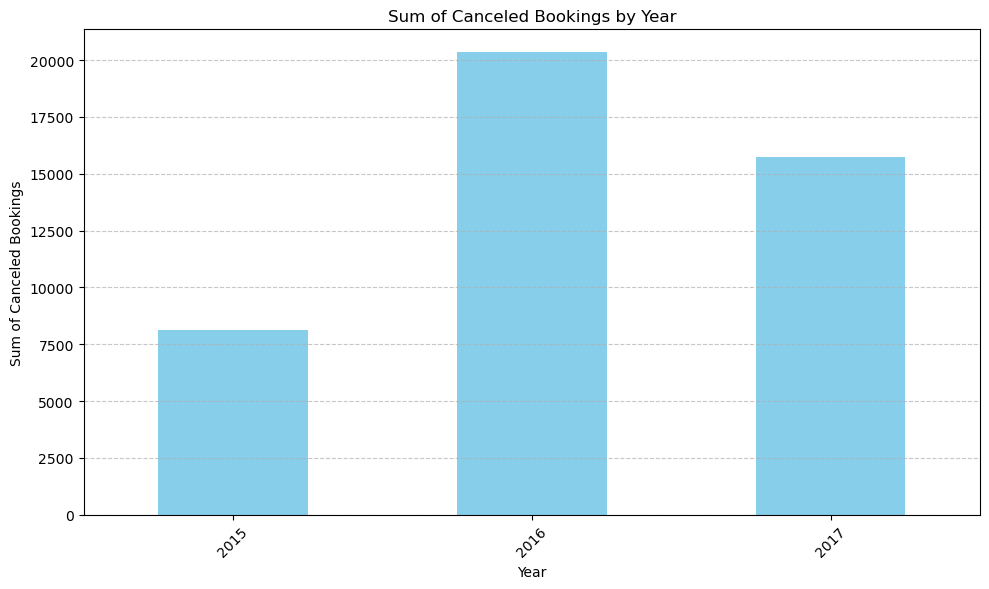

In [5]:
# Group the data by 'arrival_date_year' and calculate the sum of 'is_canceled' for each month
canceled_by_year = hotels.groupby('arrival_date_year')['is_canceled'].sum()

# Sort the data by year to ensure proper ordering in the plot
canceled_by_year = canceled_by_year.reindex([2015, 2016, 2017])
                                             
# Plot the sum of 'is_canceled' by 'arrival_date_year'
plt.figure(figsize=(10, 6))
canceled_by_year.plot(kind='bar', color='skyblue')
plt.title('Sum of Canceled Bookings by Year')
plt.xlabel('Year')
plt.ylabel('Sum of Canceled Bookings')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

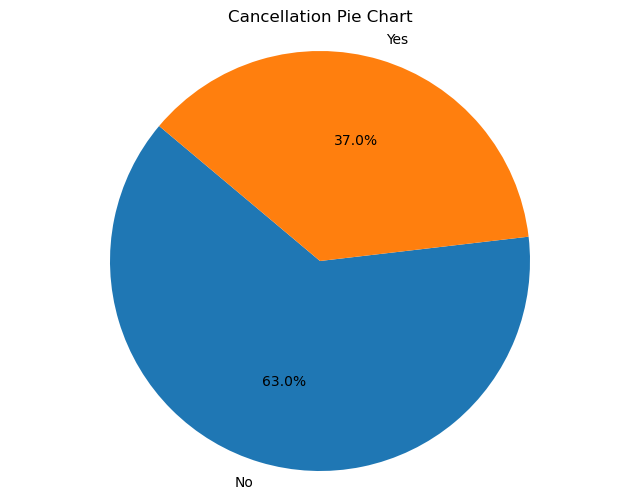

In [21]:
# Create a Pie Chart for Canceled Reservations

# Calculate the distribution of 'is_canceled'
cancel_counts = hotels['is_canceled'].value_counts()

# Create labels and sizes for the pie chart
labels = ['No', 'Yes']
sizes = cancel_counts.values

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Cancellation Pie Chart')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

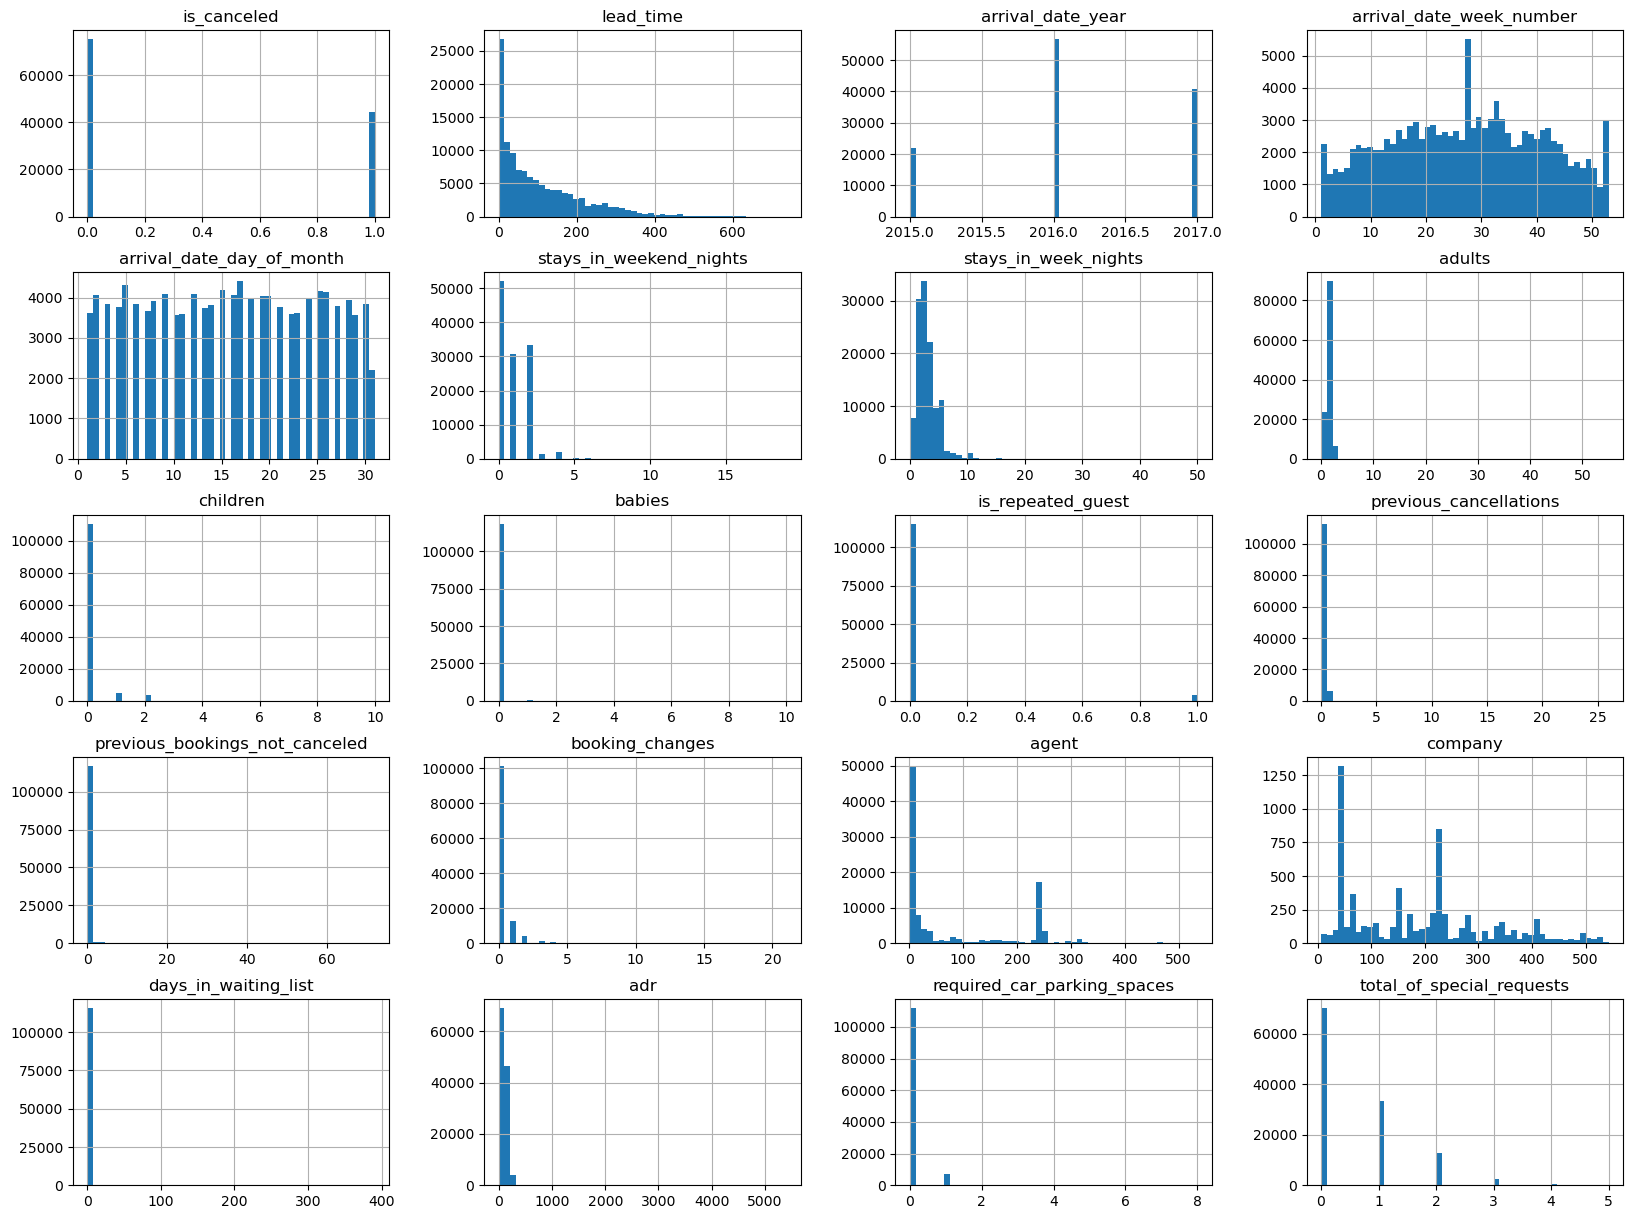

In [22]:
# Histograms for attributes in the data frame

%matplotlib inline
hotels.hist(bins = 50, figsize=(20,15))
plt.show()

/var/folders/7j/ffr8bt9n5dg654tr0_9y823h0000gn/T/ipykernel_38027/2609112433.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = hotels.corr()


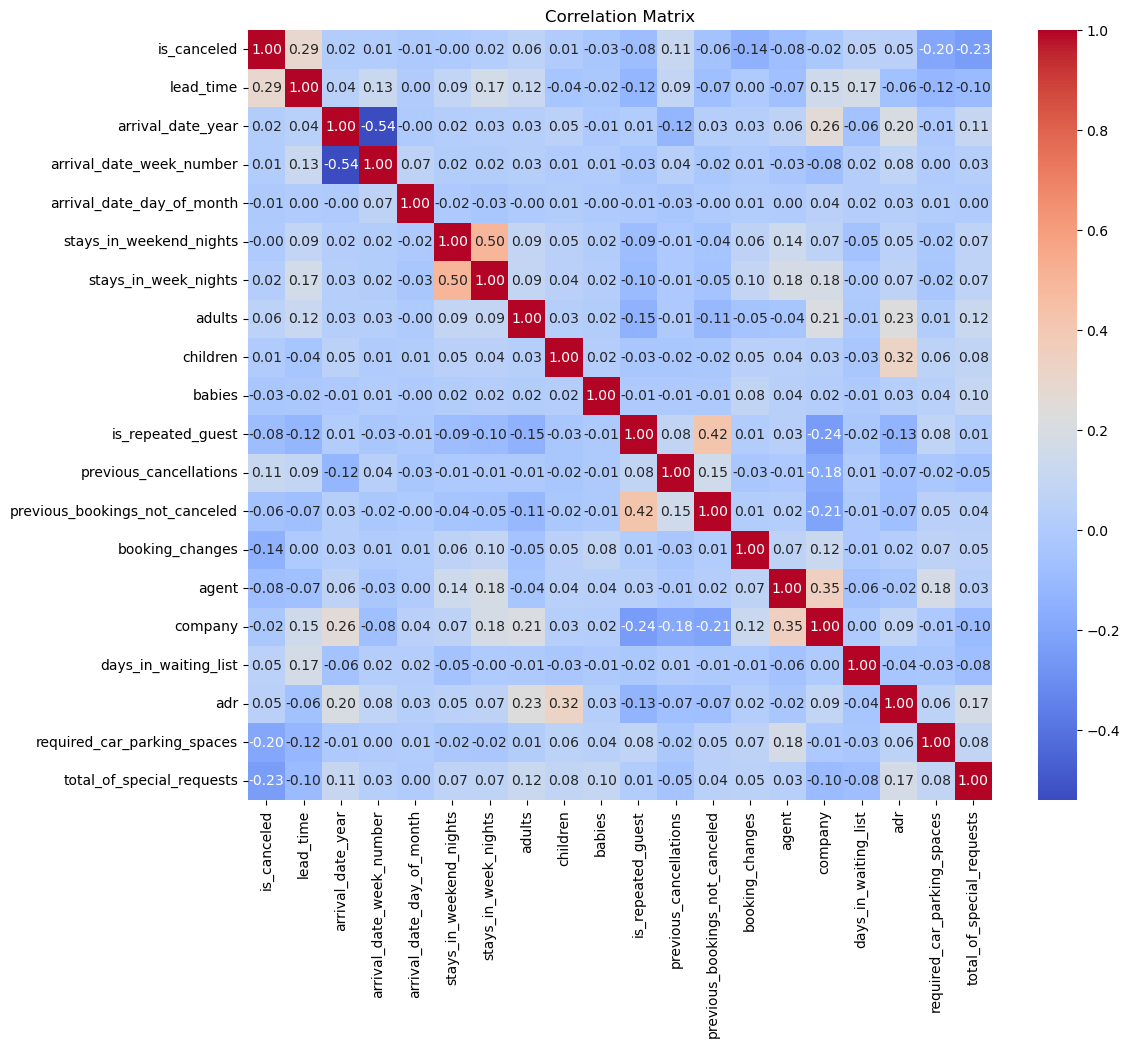

In [18]:
# Calculate the correlation matrix

corr_matrix = hotels.corr()

# Visualize the correlation matrix

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()